## Classify and plot dimensionless profiles

# Generate summary profiles
Run cluster analysis on the profiles to identify clusters of events with similar profiles.  
This is performed on the cumulative, normalised rainfall profiles.  
The objective is to group similar rainfall events based on how rainfall accumulates over time (regardless of individual intensities or durations).  
The output of this is centroids which represent the average cumulative profile of each cluster.   

### Convert cumulative rainfall data into intensity profiles
This is to better illustrate the characteristic behaviours/patterns revealed by clusters.  

This involves:  
- Converting cumulative rainfall to intensities (differentiating the cumulative rainfall with respect to time to obtain instantaneous rainfall intensities?)
- Normalising these intensities by a characteristic intensity, often the average intensity of each profile or the peak intensity.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import os
import sys
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt    
import re
import pickle
import matplotlib.patches as mpatches
from statsmodels.graphics.mosaicplot import mosaic
from tabulate import tabulate

sys.path.insert(1, '../CreatingProfiles/')
from Analyse_Events_Functions import *
from Plot_events_functions import *

In [4]:
def keep_top_ten_percent(profiles, durations, real_durations, volumes):
    # Calculate the cutoff for the top 10%
    cutoff = np.percentile(volumes, 90)

    # Get indices of values in the top 10%
    top_10_percent_indices = [i for i, x in enumerate(volumes) if x >= cutoff]

    # Extract corresponding values from the other list
    top_10_percent_profiles = [profiles[i] for i in top_10_percent_indices]
    top_10_percent_durations = [durations[i] for i in top_10_percent_indices]
    top_10_percent_volumes = [volumes[i] for i in top_10_percent_indices]
    top_10_percent_real_durations = [real_durations[i] for i in top_10_percent_indices]
    
    return top_10_percent_profiles, top_10_percent_durations, top_10_percent_real_durations, top_10_percent_volumes

def run_kmeans_clustering (num_clusters, profiles, durations):
    # Create and fit the model
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(profiles)

    # Get cluster labels for each profile
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    df = pd.DataFrame({'cluster_num': labels, 'duration': durations})
    df['duration'] = pd.to_numeric(df['duration'])
    df.groupby('cluster_num')['duration'].mean()
    return df

In [17]:
def format_data_for_plots(filepath, duration_style ='Real'):
    # Define duration bins and labels
    duration_bins = [0, 2.10, 6.45, 19.25, np.inf]
    duration_labels = ['0:15-2.10hr', '2.10:6.45hr', '6.45-19.25hr', '19.25:infinity']

    # Define loading classes
    loading_classes = ['F2', 'F1', 'C', 'B1', 'B2']

    # Load example data
    with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/{filepath}_profiles.pkl", 'rb') as f:
        profiles = pickle.load(f)
    with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/{filepath}_durations_for_profiles.pkl", 'rb') as f:
        durations = pickle.load(f)
        durations = np.float64(durations)
    with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/{filepath}_real_durations_for_profiles.pkl", 'rb') as f:
        real_durations = pickle.load(f)
    with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/{filepath}_volumes_for_profiles.pkl", 'rb') as f:
        volumes = pickle.load(f)
    with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/{filepath}_max_quintiles.pkl", 'rb') as f:
        max_quintiles = pickle.load(f)
    
    if duration_style == 'Real':
        durations = real_durations
    elif duration_style == 'AMAX_length':
        durations = durations
    
    # Recode max_quintiles into loading classes
    quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
    loadings = [quintile_mapping[q] for q in max_quintiles]

    # Categorize durations into bins
    duration_categories = pd.cut(durations, bins=duration_bins, labels=duration_labels, right=False)

    # Create a DataFrame with the data
    data = pd.DataFrame({'Profile': profiles, 'Duration': duration_categories,'Loading': loadings})

    # Drop rows with NaN values in 'Duration' (in case there are durations outside the specified bins)
    data = data.dropna(subset=['Duration'])

    # Convert Loading to a categorical type with specified order
    data['Loading'] = pd.Categorical(data['Loading'], categories=loading_classes, ordered=True)

    # Reverse the order of Duration categories
    reversed_duration_labels = duration_labels[::-1]
    data['Duration'] = pd.Categorical(data['Duration'], categories=reversed_duration_labels, ordered=True)
    return data

def create_mosaic_plot(data):    

    # Count the occurrences and reshape for mosaic plot
    count_data = data.groupby(['Loading', 'Duration']).size().unstack(fill_value=0)

    # Create a dictionary format suitable for the mosaic plot
    mosaic_data = count_data.stack().to_dict()

    # Plot the mosaic plot
    plt.figure(figsize=(12, 8))
    mosaic(mosaic_data, gap=0.01, title='Distribution of Rainfall Profiles by Duration and Loading Class')

    # Update y-label to reflect that duration categories are reversed
    plt.ylabel('Duration')
    plt.xlabel('Loading Class')
    plt.gca().invert_yaxis()  # Invert the y-axis to display the duration categories in reversed order

    plt.show();
    
def create_contingency_table(data):    
    # Create a contingency table
    contingency_table = pd.crosstab(data['Duration'], data['Loading'])

    # Convert counts to row-wise proportions (percentages)
    row_proportional_table = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

    # Round to 1 decimal place
    row_proportional_table = row_proportional_table.round(1)

    # Calculate the overall proportion for each loading category
    total_counts = contingency_table.sum(axis=0)  # Sum across all duration categories
    overall_proportion = (total_counts / total_counts.sum()) * 100  # Divide by total count to get percentage
    overall_proportion = overall_proportion.round(1)

    # Add the 'All' row to the proportional table
    row_proportional_table.loc['All'] = overall_proportion

    # Convert the proportional table to a list of lists for tabulate
    table_data = row_proportional_table.reset_index().values.tolist()
    headers = ['DurationCategory'] + row_proportional_table.columns.tolist()

    # Print the formatted table using tabulate
    print("Proportional Contingency Table with 'All' Row:")
    print(tabulate(table_data, headers=headers, tablefmt='pretty'))
    

<Figure size 864x576 with 0 Axes>

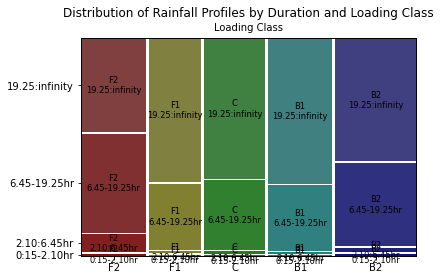

In [23]:
data = format_data_for_plots("NIMROD/NIMROD_1km_unfiltered", duration_style = 'Real')
create_mosaic_plot(data);

<Figure size 864x576 with 0 Axes>

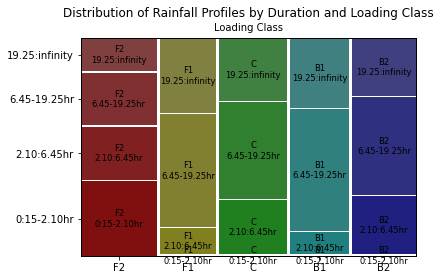

In [13]:
data = format_data_for_plots("UKCP18_30mins/bc005/model", duration_style = 'Real')
create_mosaic_plot(data);

## Compare summary profiles for 1km for 5, 10, 15, 20 clusters

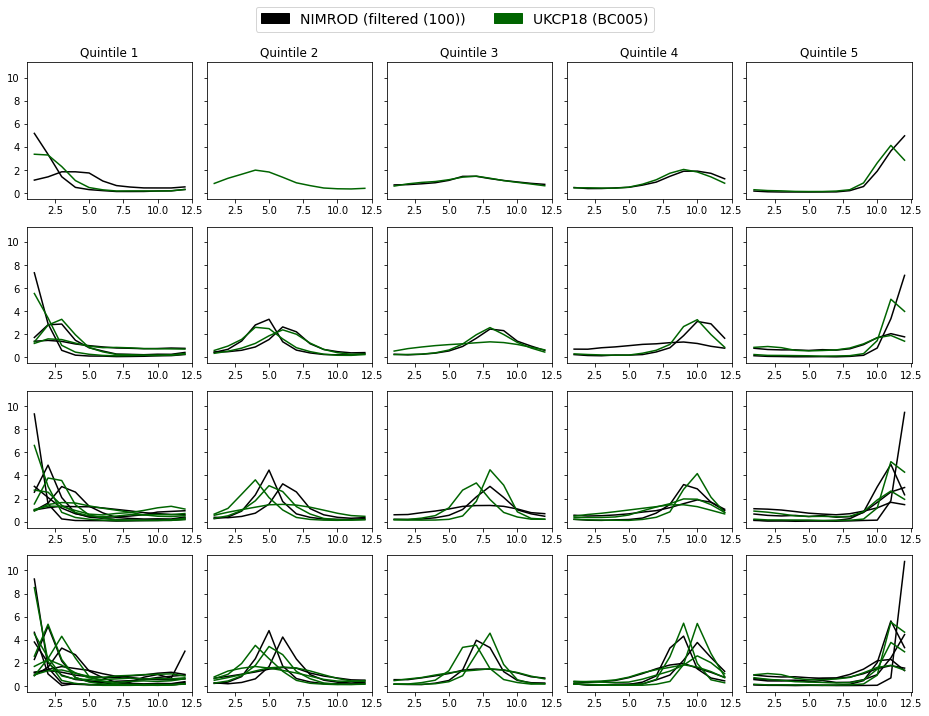

In [25]:
em='bc005'

fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(13, 10), sharey=True)
# # Define the number of clusters for each row
num_clusters_list = [5, 10, 15, 20]

# Loop through the number of clusters and plot profiles
for row, num_clusters in enumerate(num_clusters_list):
    plot_profiles(axs, "NIMROD/NIMROD_2.2km_filtered_100_profiles","NIMROD/NIMROD_2.2km_filtered_100_durations_for_profiles",
                  "NIMROD/NIMROD_2.2km_filtered_100_volumes_for_profiles", "NIMROD/NIMROD_2.2km_filtered_100_real_durations_for_profiles",
                  num_clusters, row, color='black', linestyle='solid')
    plot_profiles(axs, f"UKCP18_30mins/{em}/model_profiles",f"UKCP18_30mins/{em}/model_durations_for_profiles",
                  f"UKCP18_30mins/{em}/model_volumes_for_profiles", f"UKCP18_30mins/{em}/model_real_durations_for_profiles",
                  num_clusters, row, color='darkgreen', linestyle='solid')    

# Define the legend patches
black_patch = mpatches.Patch(color='black', label='NIMROD (filtered (100))')
green_patch = mpatches.Patch(color='darkgreen', label='UKCP18 (BC005)')

# Adjust the layout to make space for the legend
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Add the legend to the figure
fig.legend(handles=[black_patch, green_patch], loc='upper center', fontsize = 14, bbox_to_anchor=(0.5, 1), ncol=3)

# Show the plot
plt.show()

<Figure size 864x576 with 0 Axes>

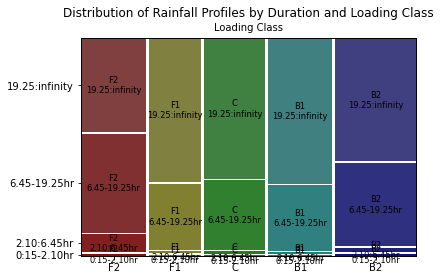

In [28]:
data = format_data_for_plots("NIMROD/NIMROD_1km_unfiltered", duration_style = 'Real')
create_mosaic_plot(data);

In [25]:
create_contingency_table(data)

Proportional Contingency Table with 'All' Row:
+------------------+------+------+------+------+------+
| DurationCategory |  F2  |  F1  |  C   |  B1  |  B2  |
+------------------+------+------+------+------+------+
|  19.25:infinity  | 13.2 | 19.0 | 20.9 | 20.8 | 26.1 |
|   6.45-19.25hr   | 10.5 | 18.2 | 22.9 | 26.7 | 21.7 |
|   2.10:6.45hr    | 8.3  | 19.4 | 24.0 | 25.1 | 23.2 |
|   0:15-2.10hr    | 34.7 | 11.8 | 13.1 | 13.8 | 26.7 |
|       All        | 20.3 | 16.0 | 18.8 | 19.9 | 24.9 |
+------------------+------+------+------+------+------+


### Plot profiles clouds

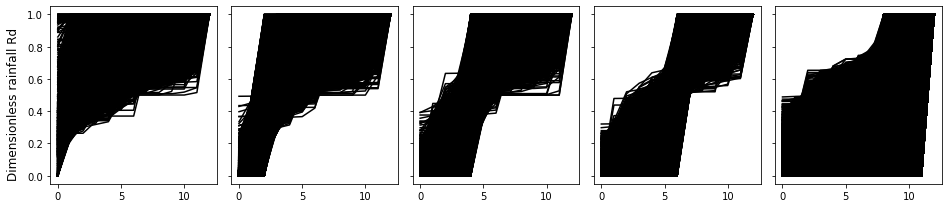

In [7]:
with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/NIMROD/NIMROD_1km_filtered_100_profiles.pkl", 'rb') as f:
    profiles = pickle.load(f)

# Prepare the subplots
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(13, 3), sharey=True)

# Example profiles (using random synthetic data for demonstration)
np.random.seed(0)  # For reproducibility

# Loop through a subset of profiles
for profile in profiles:  # Adjust indices as needed
    heaviest_segment = categorize_normalized_rainstorm(profile)
    # print("The heaviest rainfall is concentrated in segment:", heaviest_segment + 1)  # Output for clarity
    
    # Plot on the appropriate subplot based on the heaviest segment
    axs[heaviest_segment].plot(profile, label=f'Profile with heaviest in segment {heaviest_segment + 1}',
                              color='black')

# Adjust the layout
fig.tight_layout()
fig.supylabel('Dimensionless rainfall Rd', x=- 0.01)
plt.show()

# Now just considering one of the NIMROD options (filtered 100):
### Compare to RVH profiles, for each duration

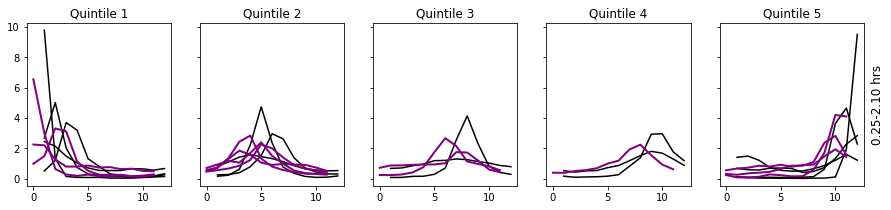

In [122]:
fig, axs = plt.subplots(ncols=5,figsize=(15, 3), sharey=True)
plot_profiles_onerow_oneduration(axs, "NIMROD/NIMROD_1km_filtered_100_profiles", "NIMROD/NIMROD_1km_filtered_100_durations_for_profiles",
               "NIMROD/NIMROD_1km_filtered_100_volumes_for_profiles", "NIMROD/NIMROD_1km_filtered_100_real_durations_for_profiles",
              (0.25, 2.10), color='black', linestyle='solid')

rvh_profiles = pd.read_csv("../CatchmentAnalysis/CreateSyntheticRainfallEvents/ObservedProfiles/kmeans_15clustersPerDur.csv")
# # Just keep prain (proportion of rainfall in each timestep)
rvh_profiles = rvh_profiles[rvh_profiles['Variable'] == 'irain']
rvh_profiles = rvh_profiles[rvh_profiles['Duration'] == '[2:10 - 6:45) hr']

for cluster_num in range(1,14):
    cluster1=rvh_profiles[rvh_profiles['Cluster']==cluster_num]
    cluster1 = cluster1[:-2]
    quintile_with_max_value = find_quintile_with_max_value(np.array(cluster1['Mean']))
    axs[quintile_with_max_value].plot(range(len(cluster1)),cluster1['Mean'], linewidth = 2, color='purple')  
    
axs[-1].annotate("0.25-2.10 hrs", xy=(1.05, 0.5), xycoords='axes fraction',
                      fontsize='large', ha='left', va='center', rotation=90);

In [124]:
this_dur = rvh_profiles[rvh_profiles['Duration'] == '[0.25 - 2:10) hr']
this_dur = rvh_profiles[rvh_profiles['Profile_shape'] == 'B2']
this_dur = this_dur.sort_values(by='Dur_bins')
this_dur


,Cluster,Dur_bins,Variable,Mean,Duration,Profile_shape,Cluster_id
1811,4,0.000000,irain,0.000000,[2:10 - 6:45) hr,B2,4-B
1814,5,0.000000,irain,0.000000,[2:10 - 6:45) hr,B2,5-B
1820,7,0.000000,irain,0.000000,[2:10 - 6:45) hr,B2,7-B
1370,4,0.041667,irain,0.555880,[2:10 - 6:45) hr,B2,4-B
1478,7,0.041667,irain,0.318643,[2:10 - 6:45) hr,B2,7-B
1406,5,0.041667,irain,0.242922,[2:10 - 6:45) hr,B2,5-B
1481,7,0.125000,irain,0.262895,[2:10 - 6:45) hr,B2,7-B
1409,5,0.125000,irain,0.089194,[2:10 - 6:45) hr,B2,5-B
1373,4,0.125000,irain,0.673246,[2:10 - 6:45) hr,B2,4-B
1376,4,0.208333,irain,0.726565,[2:10 - 6:45) hr,B2,4-B


In [120]:
    this_dur=this_dur[this_dur['Cluster']==cluster_num]
    this_dur = this_dur.sort_values(by='Dur_bins')
    this_dur = this_dur[:-1]
    this_dur

,Cluster,Dur_bins,Variable,Mean,Duration,Profile_shape,Cluster_id
578,13,0.000000,irain,0.000000,[19:25 - Inf) hr,F1,13-D
434,13,0.041667,irain,0.500145,[19:25 - Inf) hr,F1,13-D
437,13,0.125000,irain,0.736362,[19:25 - Inf) hr,F1,13-D
440,13,0.208333,irain,1.044856,[19:25 - Inf) hr,F1,13-D
443,13,0.291667,irain,1.595216,[19:25 - Inf) hr,F1,13-D
446,13,0.375000,irain,1.619210,[19:25 - Inf) hr,F1,13-D
449,13,0.458333,irain,0.967126,[19:25 - Inf) hr,F1,13-D
452,13,0.541667,irain,0.826304,[19:25 - Inf) hr,F1,13-D
455,13,0.625000,irain,0.894977,[19:25 - Inf) hr,F1,13-D
458,13,0.708333,irain,1.016643,[19:25 - Inf) hr,F1,13-D


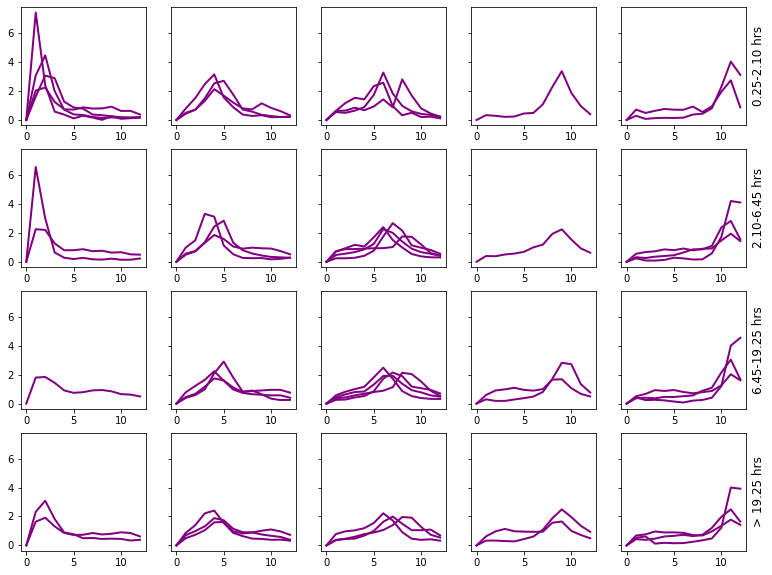

In [119]:
# Create the subplots
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(13, 10), sharey=True)
# Duration: 0.25-2.10
# plot_profiles_split_by_duration(axs, "NIMROD/NIMROD_1km_unfiltered_profiles", "NIMROD/NIMROD_1km_unfiltered_durations_for_profiles",
#                "NIMROD/NIMROD_1km_unfiltered_volumes_for_profiles", "NIMROD/NIMROD_1km_unfiltered_real_durations_for_profiles",
#               (0.25, 2.10), 0, color='black', linestyle='solid')
for cluster_num in range(1,14):
    this_dur = rvh_profiles[rvh_profiles['Duration'] == '[0.25 - 2:10) hr']
    this_dur=this_dur[this_dur['Cluster']==cluster_num]
    this_dur = this_dur.sort_values(by='Dur_bins')
    this_dur = this_dur[:-1]
    quintile_with_max_value = find_quintile_with_max_value(np.array(this_dur['Mean']))
    axs[0, quintile_with_max_value].plot(range(len(this_dur)),this_dur['Mean'], linewidth = 2, color='purple')

# Duration: 2.10-6.45    
# plot_profiles_split_by_duration(axs, "NIMROD/NIMROD_1km_unfiltered_profiles", "NIMROD/NIMROD_1km_unfiltered_durations_for_profiles",
#                "NIMROD/NIMROD_1km_unfiltered_volumes_for_profiles", "NIMROD/NIMROD_1km_unfiltered_real_durations_for_profiles",
#               (2.10,6.45), 1, color='black', linestyle='solid')
for cluster_num in range(1,14):
    this_dur = rvh_profiles[rvh_profiles['Duration'] == '[2:10 - 6:45) hr']
    this_dur=this_dur[this_dur['Cluster']==cluster_num]
    this_dur = this_dur.sort_values(by='Dur_bins')
    this_dur = this_dur[:-1]
    quintile_with_max_value = find_quintile_with_max_value(np.array(this_dur['Mean']))
    axs[1, quintile_with_max_value].plot(range(len(this_dur)),this_dur['Mean'], linewidth = 2, color='purple')  

# Duration: 6.45, 19.25
# plot_profiles_split_by_duration(axs, "NIMROD/NIMROD_1km_unfiltered_profiles", "NIMROD/NIMROD_1km_unfiltered_durations_for_profiles",
#                "NIMROD/NIMROD_1km_unfiltered_volumes_for_profiles", "NIMROD/NIMROD_1km_unfiltered_real_durations_for_profiles",
#               (6.45, 19.25), 2, color='black', linestyle='solid')
for cluster_num in range(1,14):
    this_dur = rvh_profiles[rvh_profiles['Duration'] == '[6:45 - 19:25) hr']
    this_dur=this_dur[this_dur['Cluster']==cluster_num]
    this_dur = this_dur.sort_values(by='Dur_bins')
    this_dur = this_dur[:-1]
    quintile_with_max_value = find_quintile_with_max_value(np.array(this_dur['Mean']))
    axs[2, quintile_with_max_value].plot(range(len(this_dur)),this_dur['Mean'], linewidth = 2, color='purple')  

# Duration: 19.25, float('inf')
# plot_profiles_split_by_duration(axs, "NIMROD/NIMROD_1km_unfiltered_profiles", "NIMROD/NIMROD_1km_unfiltered_durations_for_profiles",
#                "NIMROD/NIMROD_1km_unfiltered_volumes_for_profiles", "NIMROD/NIMROD_1km_unfiltered_real_durations_for_profiles",
#               (19.25, float('inf')), 3, color='black', linestyle='solid')
for cluster_num in range(1,14):
    this_dur = rvh_profiles[rvh_profiles['Duration'] == '[19:25 - Inf) hr']
    this_dur=this_dur[this_dur['Cluster']==cluster_num]
    this_dur = this_dur.sort_values(by='Dur_bins')
    this_dur = this_dur[:-1]
    quintile_with_max_value = find_quintile_with_max_value(np.array(this_dur['Mean']))

    axs[3, quintile_with_max_value].plot(range(len(this_dur)),this_dur['Mean'], linewidth = 2, color='purple') 
    
annotations = ["0.25-2.10 hrs", "2.10-6.45 hrs", "6.45-19.25 hrs", "> 19.25 hrs"]
for row in range(4):
    axs[row, -1].annotate(annotations[row], xy=(1.05, 0.5), xycoords='axes fraction',
                          fontsize='large', ha='left', va='center', rotation=90)    

## For one NIMROD option, profiles for different duration bins

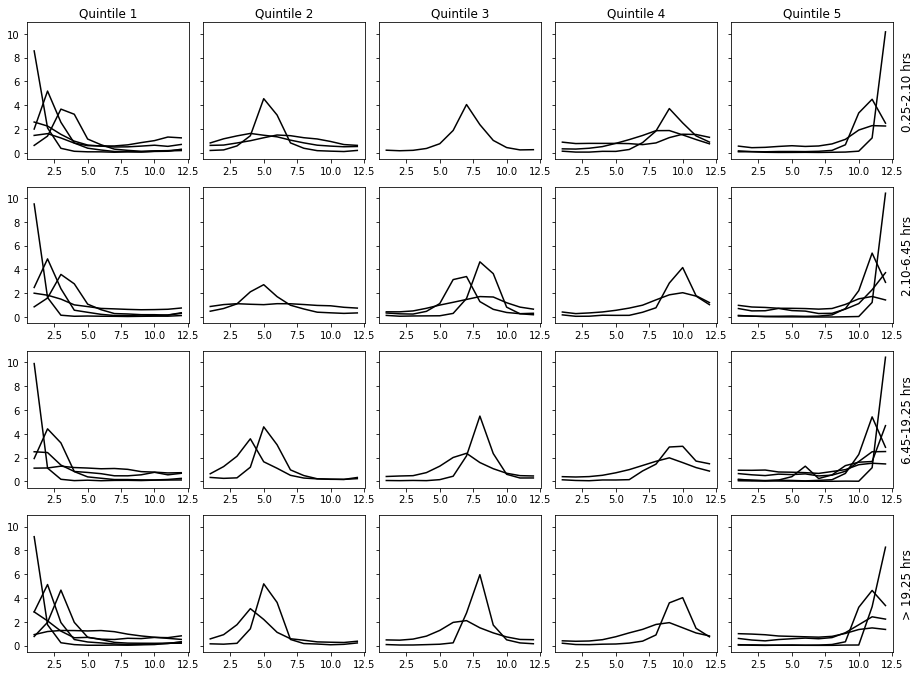

In [32]:
# Create the subplots
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(13, 10), sharey=True)
plot_profiles_split_by_duration(axs, "NIMROD/NIMROD_1km_unfiltered_profiles", "NIMROD/NIMROD_1km_unfiltered_durations_for_profiles",
               "NIMROD/NIMROD_1km_unfiltered_volumes_for_profiles", "NIMROD/NIMROD_1km_unfiltered_real_durations_for_profiles",
              (0.25, 2.10), 0, color='black', linestyle='solid')
plot_profiles_split_by_duration(axs, "NIMROD/NIMROD_1km_unfiltered_profiles", "NIMROD/NIMROD_1km_unfiltered_durations_for_profiles",
               "NIMROD/NIMROD_1km_unfiltered_volumes_for_profiles","NIMROD/NIMROD_1km_unfiltered_real_durations_for_profiles",
              (2.10, 6.45),1,color='black', linestyle='solid')
plot_profiles_split_by_duration(axs, "NIMROD/NIMROD_1km_unfiltered_profiles", "NIMROD/NIMROD_1km_unfiltered_durations_for_profiles",
               "NIMROD/NIMROD_1km_unfiltered_volumes_for_profiles",  "NIMROD/NIMROD_1km_unfiltered_real_durations_for_profiles",
              (6.45, 19.25),2,color='black', linestyle='solid') 
plot_profiles_split_by_duration(axs, "NIMROD/NIMROD_1km_unfiltered_profiles", "NIMROD/NIMROD_1km_unfiltered_durations_for_profiles",
               "NIMROD/NIMROD_1km_unfiltered_volumes_for_profiles",  "NIMROD/NIMROD_1km_unfiltered_real_durations_for_profiles",
              (19.25, float('inf')),3,color='black', linestyle='solid') 

annotations = ["0.25-2.10 hrs", "2.10-6.45 hrs", "6.45-19.25 hrs", "> 19.25 hrs"]
for row in range(4):
    axs[row, -1].annotate(annotations[row], xy=(1.05, 0.5), xycoords='axes fraction',
                          fontsize='large', ha='left', va='center', rotation=90)

# Adjust the layout to make space for the annotations
fig.tight_layout(rect=[0, 0, 1, 0.95])


## For one NIMROD option, profiles for different duration bins, compared to RVH